# Table of Contents
* [Assignment 5: Control a Marble with Reinforcement Learning](#Assignment-5:-Control-a-Marble-with-Reinforcement-Learning)
	* [Overview](#Overview)
	* [Start with This Code](#Start-with-This-Code)
	* [Requirements](#Requirements)
	* [Grading](#Grading)
	* [Extra Credit](#Extra-Credit)
	* [Check-in](#Check-in)


$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

*Zhixian (Jason) Yu*

## Overview

In this assignment, I modified the reinforcement learning code used to solve the dynamic marble problem.  This assignment focused on solving a more complex version of the marble problem in which a goal position is specified as a new state variable.

## Start with This Code

Download [A5.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/A5.tar) and extract its contents, which are

* `marble.py`
* `neuralnetworksbylayer.py`
* `layers.py`
* `scaledconjugategradient.py`
* `mlutils.py`

In [64]:
!wget http://www.cs.colostate.edu/~anderson/cs480/notebooks/A5.tar
!tar xvf A5.tar

--2017-04-22 11:57:46--  http://www.cs.colostate.edu/~anderson/cs480/notebooks/A5.tar
Resolving www.cs.colostate.edu (www.cs.colostate.edu)... 129.82.45.114
Connecting to www.cs.colostate.edu (www.cs.colostate.edu)|129.82.45.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92160 (90K) [application/x-tar]
Saving to: ‘A5.tar’

100%[======================================>] 92,160      --.-K/s   in 0.02s   

2017-04-22 11:57:46 (4.94 MB/s) - ‘A5.tar’ saved [92160/92160]

neuralnetworksbylayer.py
layers.py
scaledconjugategradient.py
mlutils.py
marble.py


In [65]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

To define a reinforcement learning problem, we need functions that return

* initial the state of the environment,
* a next state given a current state and an action,
* a reinforcement value, and
* an action to take, given the current state. For this we define an $\epsilon$-greedy policy.

Let's first define the set of valid actions.  For our simple one-dimensional marble problem, we can push left, right, or not push at all.

To train the network with different goals, several functions were modified:
1. initialState(): add one additioinal parameter to the state as the random goal generated from 1 to 9
2. nextState(): also return/keep the target of previous state
3. reinforcement(): change hard-coded 5 to the recorded goal
4. plotStatus(): make several updates to make it work for plotting
5. testIt(): add a parameter to indicate the tested goal; update plotting parameters
6. Create a new function marble_run(); change the number of elements in status from 2 to 3
7. Update the input dimension of neural network from 3 to 4. 

In [165]:
validActions = np.array([ -1, 0, 1])

def initialState():
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()), 
                    1+8*np.random.random_sample()]) ### UPDATE: add a random goal from 1 to 9

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0, s[2]]) ### UPDATE: also return the target
    elif s[0] > 10:
        s = np.array([10,0, s[2]]) ### UPDATE: also return the target
    return s

def reinforcement(s):  # s is new state
    goal = s[2]  ### UPDATE: goal is s[2] instead of hard-coded 5
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [67]:
def makeSamples(qnet, nStepsPerStart):
    samples = []
    state = initialState()
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

Now we can play.  Define constants we need.

In [91]:
#def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace):
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace):
    target = X[0][2] ### UPDATE
    
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    #plt.plot([0,X.shape[0]], [5,5],'--',alpha=0.5,lw=5)
    ### UPDATE: target line is not always 5
    plt.plot([0,X.shape[0]], [target, target],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    
    plt.subplot(4,3,3)
    #qs = qnet.use(np.array([[s,0,a] for a in validActions for s in range(11)]))
    ### UPDATE: use of neural network requires target as part of the input
    qs = qnet.use(np.array([[s, 0, target,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    #plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.fill_between([target-1, target+1],[-5,-5],[5,5],color="red",alpha=0.3) ### UPDATE: change the target region
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    #qs = qnet.use(np.array([[xsflat[i],ysflat[i],a] for a in validActions for i in range(len(xsflat))]))
    ### UPDATE: use of neural network requires target as part of the input
    qs = qnet.use(np.array([[xsflat[i], ysflat[i],target,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

#def testIt(qnet,nTrials,nStepsPerTrial):
def testIt(qnet, nTrials, nStepsPerTrial, target = 5):   ### UPDATE: include the target to be tested
    xs = np.linspace(0,10,nTrials)
    #plt.subplot(4,3,12)  ### UPDATE: to make this function useful for other situations too
    for x in xs:
        #s = [x,0] ## 0 velocity
        s = [x, 0, target] ###UPDATE: status includes the target position
        xtrace = np.zeros((nStepsPerTrial,2))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            #xtrace[step,:] = s
            ### UPDATE: only the position and velocity are needed for xtrace
            xtrace[step,:] = s[:-1]
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        #plt.plot([5,5],[-5,5],'--',alpha=0.5,lw=5)
        plt.plot([target,target],[-5,5],'--',alpha=0.5,lw=5) ### UPDATE: change the target line 
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [113]:
def marble_run(qnet, gamma, nTrials, nStepsPerTrial, nSCGIteratioins, finalEpsilon):
    epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
    fig = plt.figure(figsize=(15,15))

    epsilon = 1
    epsilonTrace = np.zeros(nTrials)
    rtrace = np.zeros(nTrials)

    for trial in range(nTrials):

        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        samples = makeSamples(qnet, nStepsPerTrial)

        #ns = 2
        ### UPDATE: number of states (ns) is updated from 2 to 3
        ns = 3
        na = 1
        X = samples[:, :ns+na]
        R = samples[:, ns+na:ns+na+1]
        nextX = samples[:, ns+na+1:]
        nextQ = qnet.use(nextX)
        qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
        
        # Decay epsilon
        epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        rtrace[trial] = np.mean(R)

        if trial % (nTrials//10) == 0 or trial == nTrials-1:
            plt.clf()
            plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
            plt.subplot(4,3,12) ### UPDATE
            testIt(qnet,10,500)
            clear_output(wait=True)
            display(fig);
            plt.pause(0.01)

        # print('Trial',trial,'mean R',np.mean(R))
    clear_output(wait=True)

In [147]:
def policy_plot_0(qnet, target = 5):
    '''This function is used to test the efficacy of a model'''
    qs = qnet.use(np.array([[s, 0, target,a] for a in validActions for s in range(11)]))
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy (target = %s)" %(target))
    plt.axis("off")

## Test different parameters

Next I test several sets of parameters including the number of iterations and different neural network architectures.<br \>
1. Marble_run parameter: network, gamma, nTrials, nStepsPerTrial, nSCGIterations, finalEpsilon<br \>
2. Neural network parameter: Number of hidden layers and number of nodes in each hidden layer

In [141]:
nh = [5,5]
#qnet = nn.NeuralNetwork([3] + nh + [1])  # [3, 5, 5, 1]
### UPDATE: the input of the neural net containing (x, v, g, a) 
qnet_1 = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
#qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1)))
### UPDATE: the input range for target is from 1 to 9
qnet_1.setInputRanges(( (0, 10), (-3, 3), (1, 9),(-1,1)))

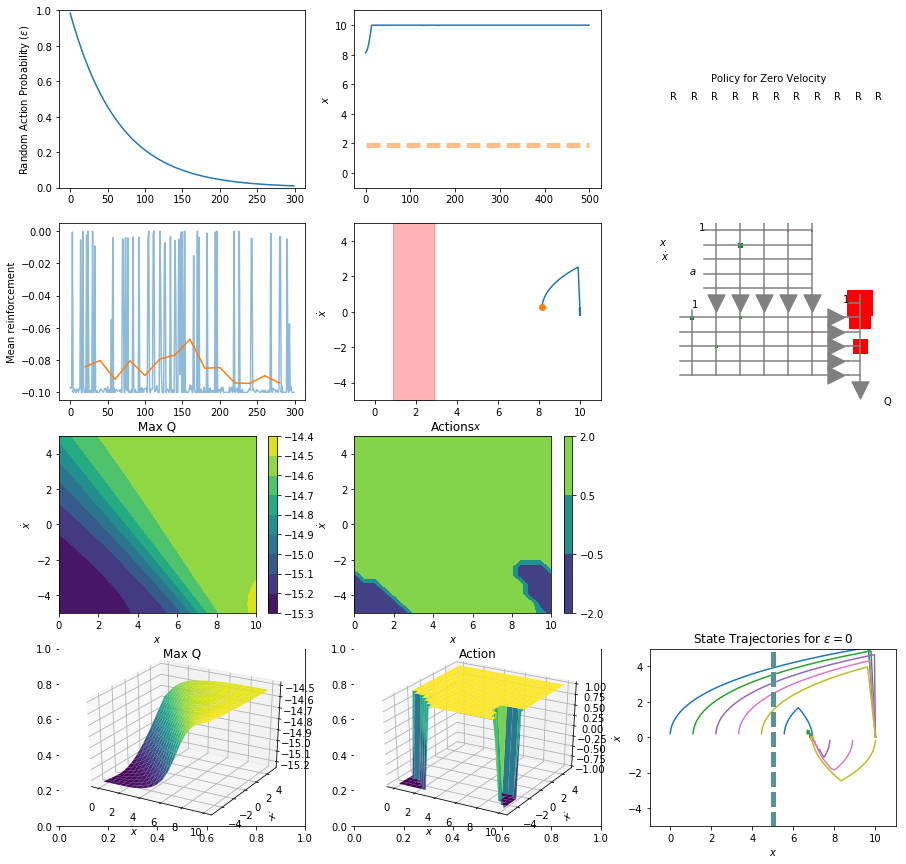

In [142]:
marble_run(qnet_1, 0.999, 300, 500, 30, 0.01)

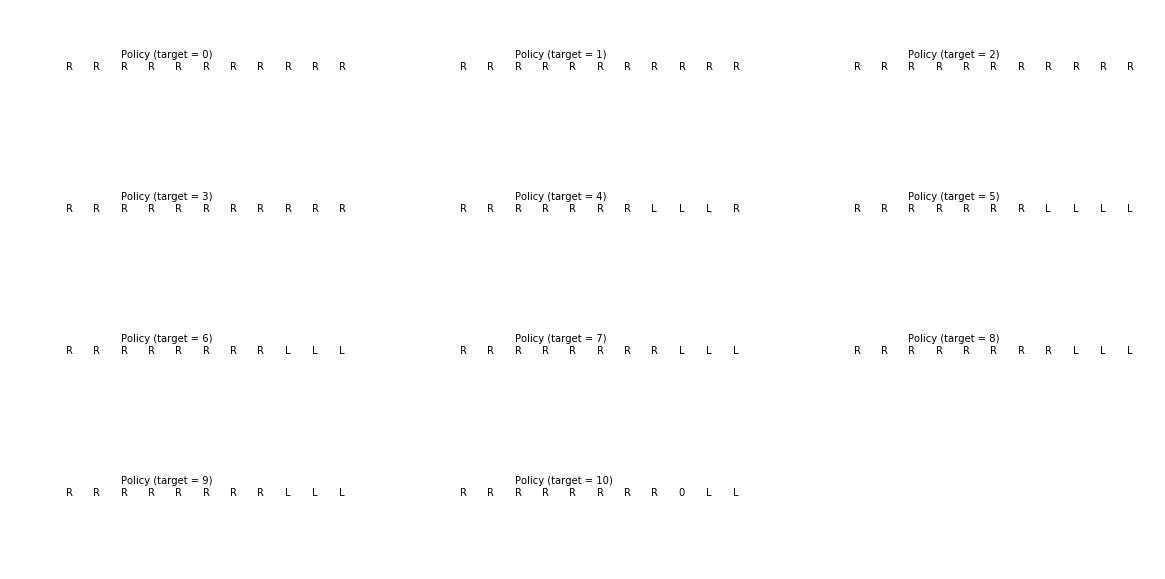

In [143]:
fig = plt.figure(figsize=(20,10))
for i in range(11):
    plt.subplot(4,3,i+1)
    policy_plot_0(qnet_1, i)

Apparently the training is not optimal. Next I try to increae the number of iterations.

In [130]:
nh = [5,5]
qnet_2 = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet_2.setInputRanges(( (0, 10), (-3, 3), (1, 9),(-1,1)))

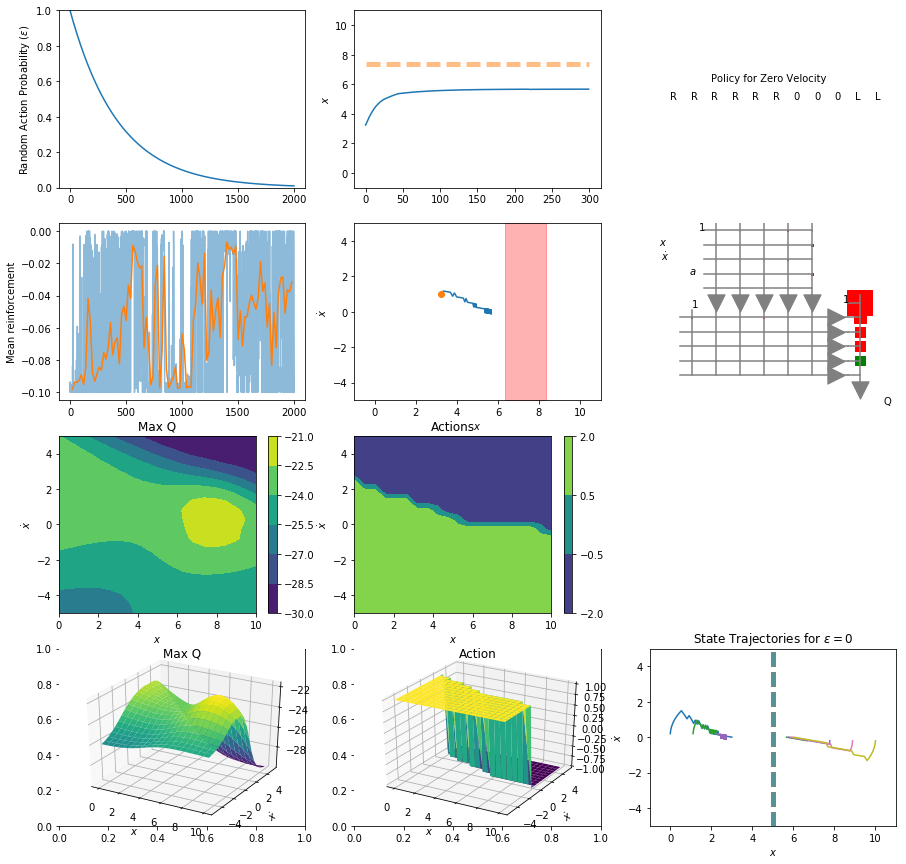

In [131]:
marble_run(qnet_2, 0.999, 2000, 300, 30, 0.01)

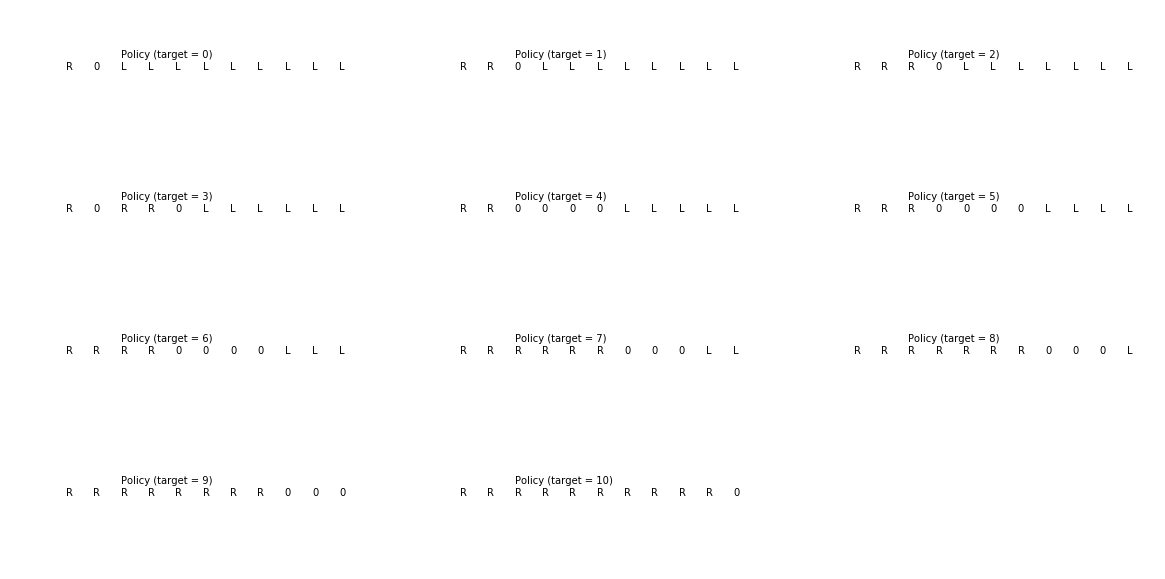

In [132]:
fig = plt.figure(figsize=(20,10))
for i in range(11):
    plt.subplot(4,3,i+1)
    policy_plot_0(qnet_2, i)

Apparently some of cases are relatively optimized such as whe target <=2. However, most of cases are not optimized, and the marble cannot determine a direction to go especially when target >=4. 

Next I try increasing the number of steps per iteration see if it can promote the efficacy of the system

In [133]:
nh = [5,5]
qnet_3 = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet_3.setInputRanges(( (0, 10), (-3, 3), (1, 9),(-1,1)))

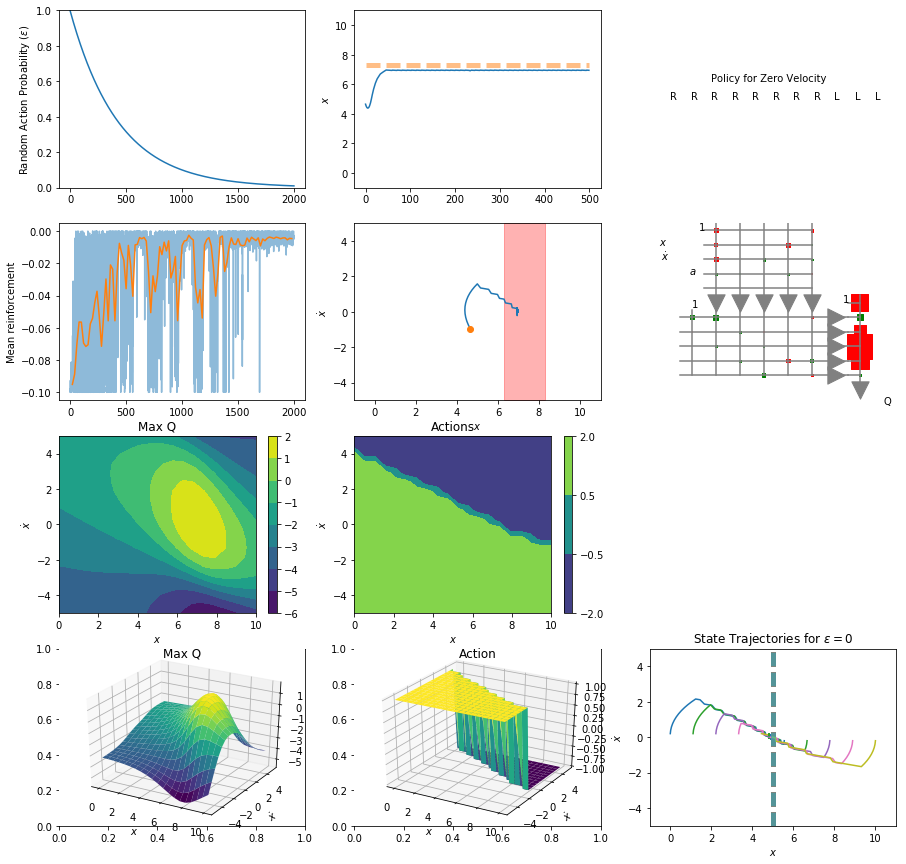

In [134]:
marble_run(qnet_3, 0.999, 2000, 500, 30, 0.01)

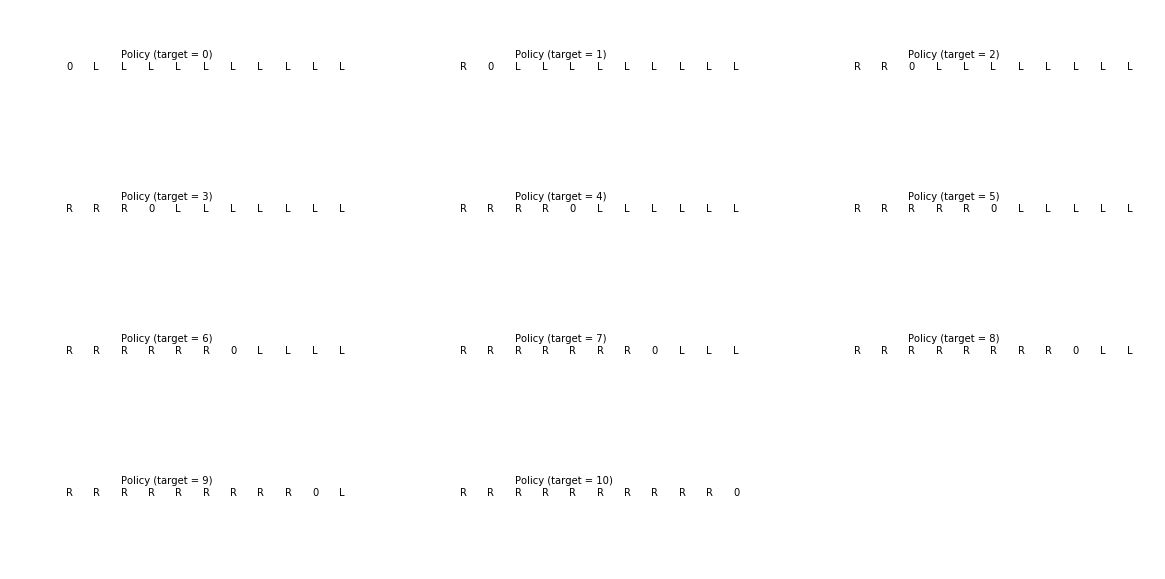

In [135]:
fig = plt.figure(figsize=(20,10))
for i in range(11):
    plt.subplot(4,3,i+1)
    policy_plot_0(qnet_3, i)

These parameters produce relatively accurate results: when the marble is in the position of the target, it does not need to move. If the marble is to the left of the target, it needs to move right; vice versa. This is true for every case shown in the above figure. The mean reinforcement value also seems to stablize with a value close to 0. 

Next I try different neural network structures to see if they can promote the efficacy of the system.

In [136]:
nh = [5,5,5] #3 hidden layers, each layer with 5 nodes
qnet_4 = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet_4.setInputRanges(( (0, 10), (-3, 3), (1, 9),(-1,1)))

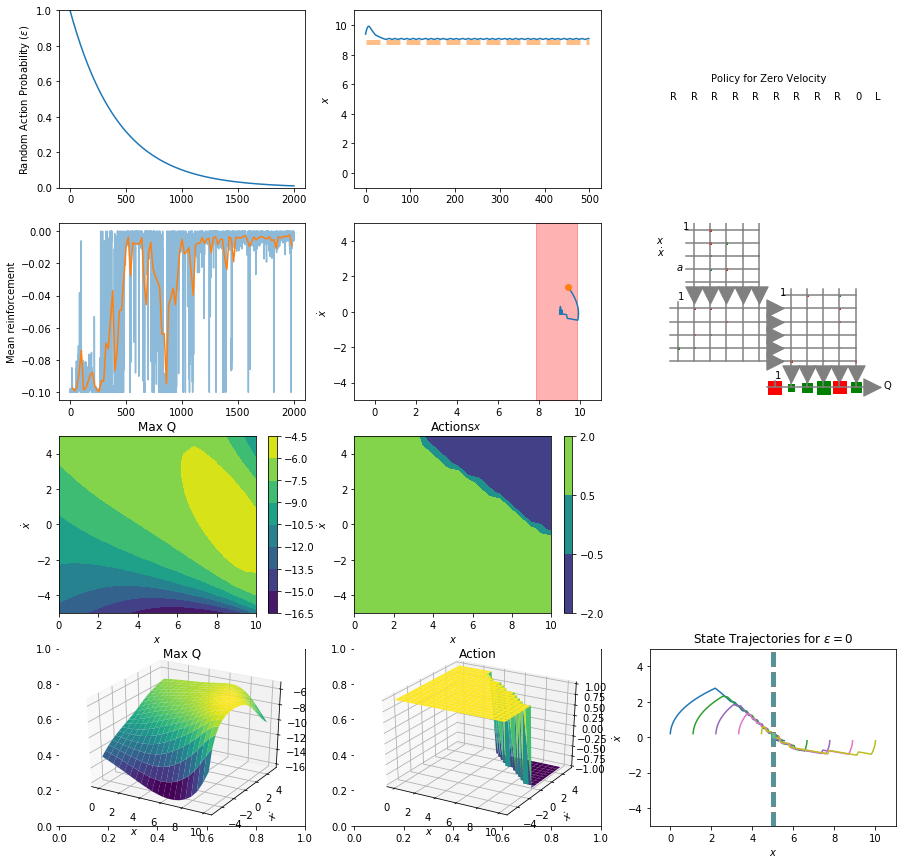

In [137]:
marble_run(qnet_4, 0.999, 2000, 500, 30, 0.01)

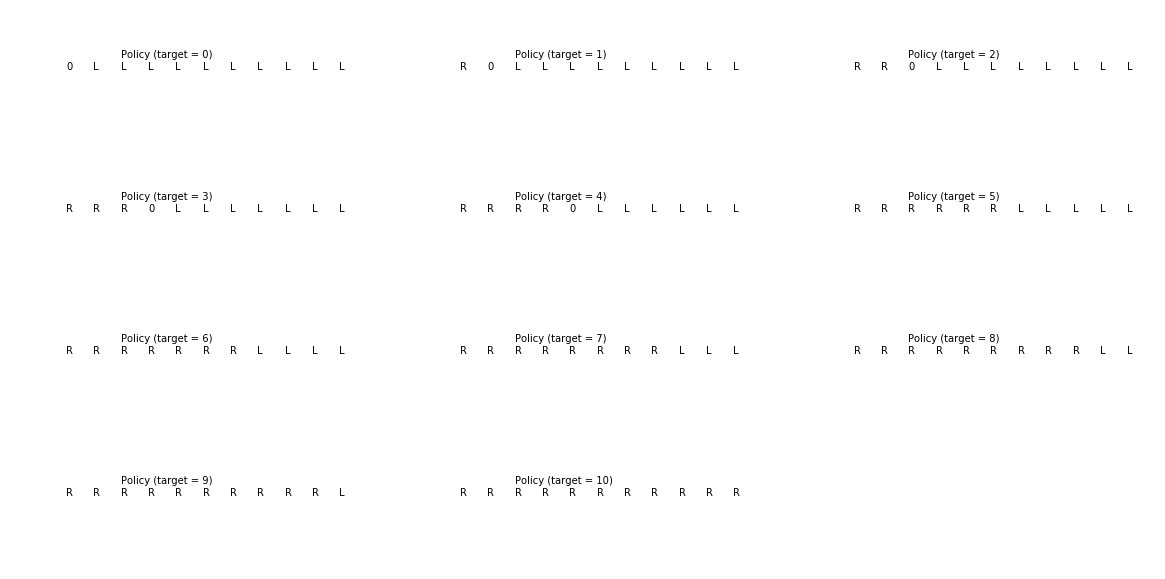

In [138]:
fig = plt.figure(figsize=(20,10))
for i in range(11):
    plt.subplot(4,3,i+1)
    policy_plot_0(qnet_4, i)

Compared with previous neural network, [5,5,5] has a worse performance. It could be an overfitting problem, or we do not have enough iterations. Since [5,5] is already relatively optimal, it is chosen as the model for the following analysis.

In [144]:
best_qnet = qnet_3

## The response for different goal positions

### Figure 1: predicted trajectories for goal positions at 0, 1, ..., 10

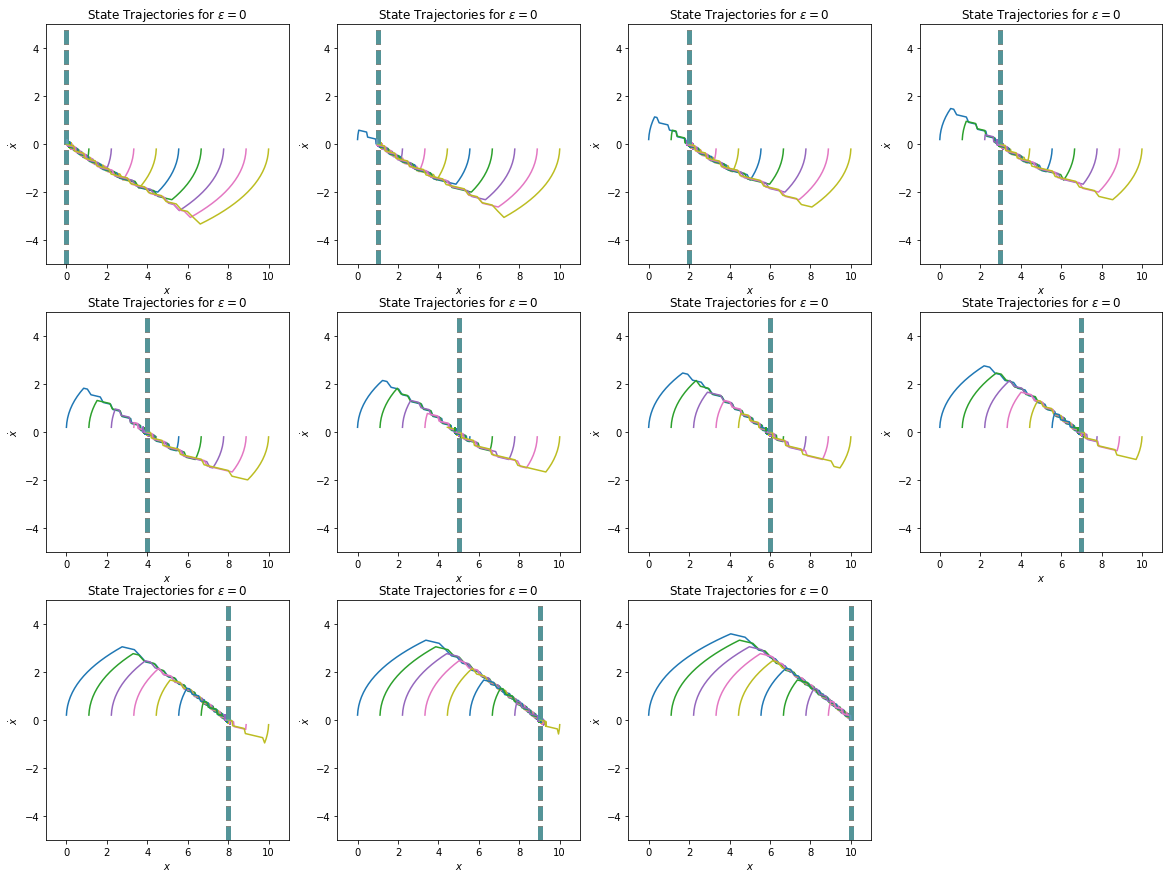

In [145]:
fig = plt.figure(figsize=(20,15))
for i in range(11):
    plt.subplot(3,4,i+1)
    testIt(best_qnet, 10, 500, target = i)

As we can see from the figure, in most cases (if not every case) the marble can move to the target. The marble is intelligent to move faster when it is away from the target, but slower when it is close. 

### Figure 2: MaxQ contour plots for goal positions at 0, 1, ..., 10

In [104]:
def Q_con(qnet, target = 5):
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i], ysflat[i],target,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q, target = %i" %(target))

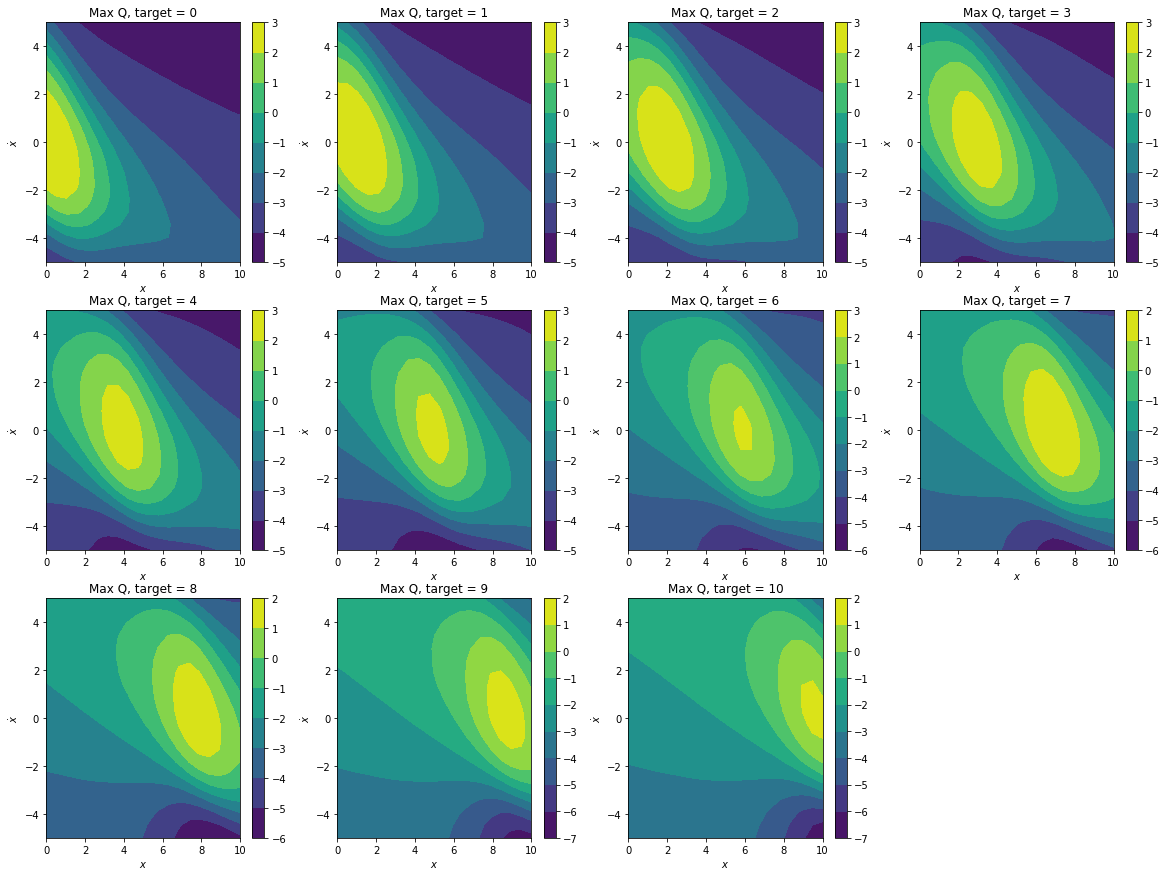

In [146]:
fig = plt.figure(figsize=(20,15))
for i in range(11):
    plt.subplot(3,4,i+1)
    Q_con(best_qnet, i)

Based on the Q value contour maps, this network is working well in terms of moving towards the target. The highest Q value almost always centers at position = target and velocity = 0, and the shape is tilted to the right angle.

### Figure 3: Best action plots for goal positions at 0, 1, ..., 10

In [150]:
def act_con(qnet, target = 5):
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i], ysflat[i],target,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions (target = %s)" %(target))

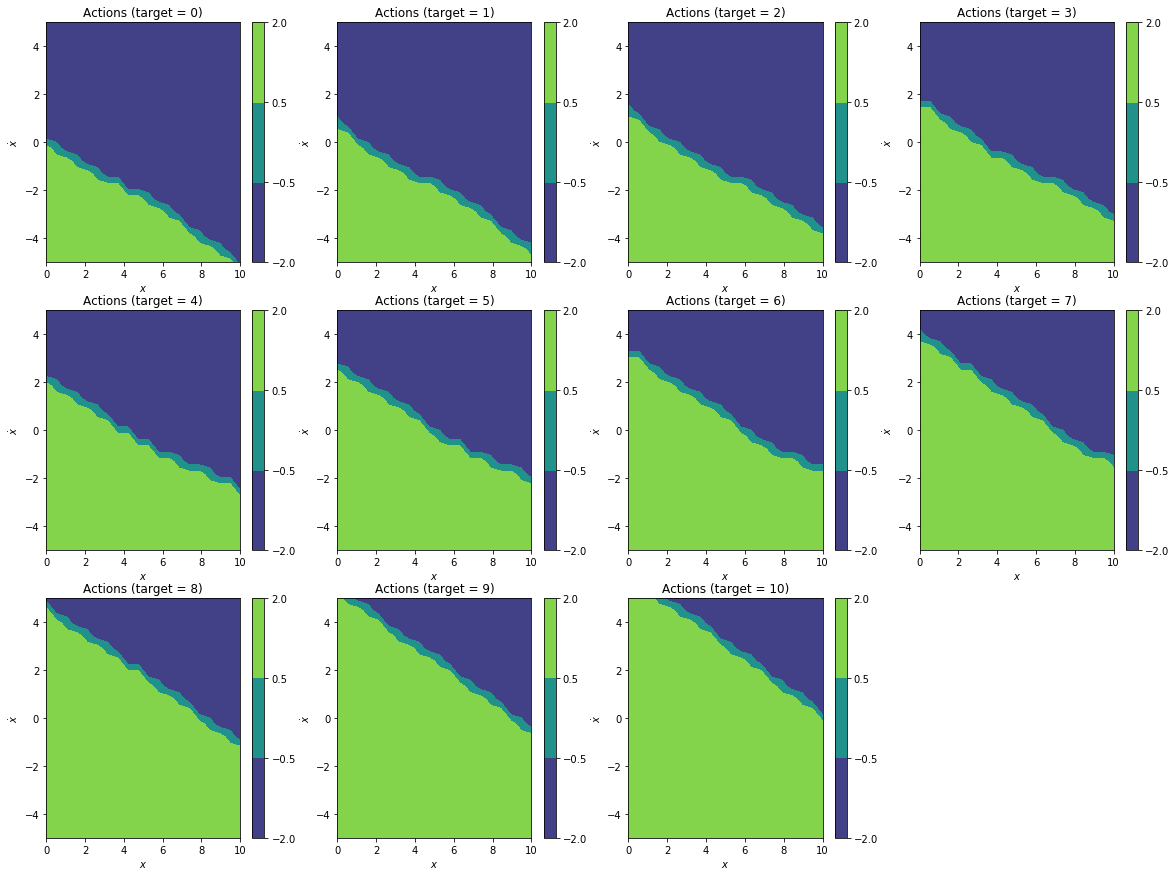

In [151]:
fig = plt.figure(figsize=(20,15))
for i in range(11):
    plt.subplot(3,4,i+1)
    act_con(best_qnet, i)

Similarly with the Q value contour plot and sample trajectories, the best actions of the marble are reasonable in terms of the target. When the marble is to the left of the target, it needs to move right (positive speed); vice versa. 

## Summary

1. Including the goal position requires more iterations to train the network.
2. Best parameters: 
    1. network: 2 hidden layers, each layer with 5 units
    2. gamma: 0.999
    3. number of trials: 2000
    4. nStepsPerTrial: 500
    5. nSCGIterations: 30
    6. finalEpsilon: 0.01

## Extra Credit

One point of extra credit will be given for completing each of the following things. These points will be used at the end of the semester to add to your semester average and possibly bump up your letter grade.

* Change the marble's world from one dimension to two. Add graphs of the marble's movement in the two-dimensional plan.
* Increase the number of valid actions from three to seven.
* Add a variable wind as a force on the marble, along with another state variable that indicates wind speed and direction.
* Add a second marble with its own RL agent.  Add negative reinforcement if they bump into each other.
* Add areas of increased friction to the track.

For all of these, demonstrate the effects and write about what you observe.

## Extra credit implementation

I tried changing the world from 1 dimension to 2, and increasing the number of actions from 3 to 7.

In [283]:
# 7 valid actions using cartesian axis
validActions_2d = np.array([ [0,0], [0,-1], [0,1], [-1,0], [1,0], [1,1], [-1,-1] ])

def initialState_2d():
    return np.array([10*np.random.random_sample(), 10*np.random.random_sample(),  # coordinates of (x,y)
                     3*(0.5-np.random.random_sample()), 3*(0.5-np.random.random_sample()), # speed in x and y (vx, vy)
                     1+8*np.random.random_sample(), 1+8*np.random.random_sample()  # goal of the marble
                    ])
                     #3*(0.5-np.random.random_sample()), 3*(0.5-np.random.random_sample()), #
                    #1+8*np.random.random_sample()]) ### UPDATE: add a random goal from 1 to 9

def nextState_2d(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[2]                  # Update position in x
    s[2] += deltaT * (2 * a[0] - 0.2 * s[2])  # Update velocity in x. Includes friction in x
    s[1] += deltaT * s[3]                  # Update position in y
    s[3] += deltaT * (2 * a[1] - 0.2 * s[3])  # Update velocity in y. Includes friction in y
    
    if s[0] < 0:        # Bound next position for x. If at limits, set velocity to 0.
        s[0] = 0
        s[2] = 0
    elif s[0] > 10:
        s[0] = 10
        s[2] = 0
    
    if s[1] < 0:        # Bound next position for y. If at limits, set velocity to 0.
        s[1] = 0
        s[3] = 0
    elif s[1] > 10:
        s[1] = 10
        s[3] = 0
    
    return s

def reinforcement_2d(s):  # s is new state
    #goal = s[2]  ### UPDATE: goal is s[2] instead of hard-coded 5
    dist = np.sqrt((s[0]-s[4])**2 + (s[1]-s[5])**2 )
    return 0 if dist < 1 else -0.1

def policy_2d(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions_2d.shape[0], 1)), validActions_2d))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions_2d[actioni]

Now we need a function to generate a bunch of samples that are interactions with the marble.

In [284]:
def makeSamples_2d(qnet, nStepsPerStart):
    samples = []
    state = initialState_2d()
    act = policy_2d(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState_2d(state, act)
        r = reinforcement_2d(newState)
        newAct = policy_2d(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act[0], act[1], r] + newState.tolist() + [newAct[0],newAct[1]])
        state = newState
        oldact = act
        act = newAct
    #print(samples[0])
    return np.array(samples)

Now we can play.  Define constants we need.

In [285]:
import matplotlib.collections as mcoll
# function cololine() and make_segments() were modified from online source
def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def plotStatus_2d(qnet, X, R, trial, epsilonTrace, rtrace):
    targetX = X[0,4]
    targetY = X[0,5]
    
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    
    plt.subplot(4,3,2)
    #plt.plot(X[:,0], 'r', X[:,1], 'b')
    lc = colorline(X[:,0], X[:,1], cmap='hsv')
    cbar = plt.colorbar(lc)
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.text(1.2, 1, str(X.shape[0]))
    #cbar.ax.text(1, .5, str(X.shape[0]//2))
    cbar.ax.text(1.2, 0, str(0))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('# of steps per trial', rotation=270)
    plt.plot(X[0,4],X[0,5],'*', markersize =20, color='k') # coordinate of the goal
    #plt.plot([0,X.shape[0]], [5,5],'--',alpha=0.5,lw=5)
    ### UPDATE: target line is not always 5
    #plt.plot([0,X.shape[0]], [target, target],'--',alpha=0.5,lw=5)
    plt.ylabel("$y$")
    plt.xlabel("$x$")
    plt.ylim(-1,11)
    plt.xlim(-1,11)
    #plt.show()
    

    plt.subplot(4,3,3)
    #validActions_2d = np.array([ [0,0], [0,-1], [0,1], [-1,0], [1,0], [1,1], [-1,-1] ])
    acts_2d = ['0','S','N','W','E','NE','SW']
    for sx in range(11):
        for sy in range(11):            
            qs = qnet.use(np.array([[sx, sy, 0, 0, targetX, targetY, a[0],a[1]] for a in validActions_2d]))
            actsiByState = np.argmax(qs.reshape((len(validActions_2d),-1)),axis=0)
            plt.text(sx,sy,acts_2d[actsiByState[0]])
            plt.xlim(-1,11)
            plt.ylim(-1,11)
    plt.title("Policy for Zero Velocity")
    plt.axis("off")
    #plt.annotate('E', xy=(-1, 0), xytext=(-2, 0))
    
    
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    
    plt.subplot(4,3,5)
    #plt.plot(X[:,0],X[:,2])
    lc = colorline(X[:,0], X[:,2], cmap='hsv')
    cbar = plt.colorbar(lc)
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.text(1.2, 1, str(X.shape[0]))
    #cbar.ax.text(1, .5, str(X.shape[0]//2))
    cbar.ax.text(1.2, 0, str(0))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('# of steps per trial', rotation=270)
    plt.plot(X[0,0],X[0,2],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    #plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.fill_between([targetX-1, targetX+1],[-5,-5],[5,5],color="red",alpha=0.3) ### UPDATE: change the target region
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    
    
    plt.subplot(4,3,6)
    #qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])
    lc = colorline(X[:,1], X[:,3], cmap='hsv')
    cbar = plt.colorbar(lc)
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.text(1.2, 1, str(X.shape[0]))
    #cbar.ax.text(1, .5, str(X.shape[0]//2))
    cbar.ax.text(1.2, 0, str(0))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('# of steps per trial', rotation=270)
    plt.plot(X[0,1],X[0,3],'o')
    plt.xlabel("$y$")
    plt.ylabel("$\dot{y}$")
    #plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.fill_between([targetY-1, targetY+1],[-5,-5],[5,5],color="red",alpha=0.3) ### UPDATE: change the target region
    plt.xlim(-1,11)
    plt.ylim(-5,5)

    
    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    #qs = qnet.use(np.array([[xsflat[i],ysflat[i],a] for a in validActions for i in range(len(xsflat))]))
    ### UPDATE: use of neural network requires target as part of the input
    qs_x = qnet.use(np.array([[xsflat[i], 0, ysflat[i],0, targetX,targetY, a[0],a[1]] 
                            for a in validActions_2d for i in range(len(xsflat)) 
                           ]))
    #qs = np.array(qs).squeeze().T
    qs_x = qs_x.reshape((len(validActions_2d),-1)).T
    qsmax_x = np.max(qs_x,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax_x)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q wrt x")
    
    
    plt.subplot(4,3,8)
    qs_y = qnet.use(np.array([[0, xsflat[i], 0, ysflat[i], targetX,targetY, a[0],a[1]] 
                            for a in validActions_2d for i in range(len(xsflat)) 
                           ]))
    #qs = np.array(qs).squeeze().T
    qs_y = qs_y.reshape((len(validActions_2d),-1)).T
    qsmax_y = np.max(qs_y,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax_y)
    plt.colorbar(cs)
    plt.xlabel("$y$")
    plt.ylabel("$\dot{y}$")
    plt.title("Max Q wrt y")
    
    plt.subplot(4,3,9)
    qnet.draw(["$x$",'$y$',"$\dot{x}$","$\dot{y}$","$a_x$","$a_y$"],["Q"])
    
    
    '''
    plt.subplot(4,4,11)
    for i,ind in enumerate(np.argmax(qs_x, axis=1)):
        acts_x = acts_2d[ind]
        #cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
        plt.text(xsflat[i],ysflat[i],acts_x)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions wrt x")
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    
    plt.subplot(4,4,12)
    for i, ind in enumerate(np.argmax(qs_y, axis=1)):
        acts_y = acts_2d[ind]
        #cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
        plt.text(xsflat[i],ysflat[i],acts_y)
    plt.xlabel("$y$")
    plt.ylabel("$\dot{y}$")
    plt.title("Actions wrt y")
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    '''
    '''
    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")
'''
    '''
    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")
'''
#def testIt(qnet,nTrials,nStepsPerTrial):
def testIt_2d(qnet, nTrials, nStepsPerTrial, target = (0,0)):   ### UPDATE: include the target to be tested
    #randomly generate nTrials starting points 
    for i in range(nTrials):
        test_x = 10*np.random.random_sample()
        test_y = 10*np.random.random_sample()
        s = [test_x, test_y, 0, 0, target[0],target[1]] ###UPDATE: status includes the target position
        xtrace = np.zeros((nStepsPerTrial,4))
        for step in range(nStepsPerTrial):
            a = policy_2d(qnet, s, 0.0)  # epsilon = 0
            s = nextState_2d(s,a)
            xtrace[step,:] = s[:-2]
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-1,11)
        plt.plot([target[0],target[0]],[-1,11],'--',alpha=0.5,lw=5)
        plt.plot([-1,11],[target[1],target[1]],'--',alpha=0.5,lw=5)
        plt.ylabel('$y$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')
        

In [286]:
#See UPDATE
def marble_run_2d(nh, gamma, nTrials, nStepsPerTrial, nSCGIteratioins, finalEpsilon):
    epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
    fig = plt.figure(figsize=(15,15))

    epsilon = 1
    epsilonTrace = np.zeros(nTrials)
    rtrace = np.zeros(nTrials)
    
    ns = len(initialState_2d()) # number of elements in state vector
    na = len(validActions_2d[0]) # number of actiions
    qnet = nn.NeuralNetwork([ns + na] + nh + [1]) 
    qnet.setInputRanges(( (0, 10), (0, 10),
                         (-3, 3), (-3, 3),
                         (1,9), (1,9),
                         (-1,1), (-1,1)
                        ))
    
    for trial in range(nTrials):

        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        samples = makeSamples_2d(qnet, nStepsPerTrial)

        X = samples[:, :ns+na]
        R = samples[:, ns+na:ns+na+1]
        nextX = samples[:, ns+na+1:]
        nextQ = qnet.use(nextX)
        qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
        
        # Decay epsilon
        epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        rtrace[trial] = np.mean(R)


    return (qnet, X, R, trial, epsilonTrace, rtrace)

In [290]:
(qnet_2d, X_2d, R_2d, trial_2d, epsilonTrace_2d, rtrace_2d) = marble_run_2d([5,5],0.999,5000, 1000, 60, 0.001)

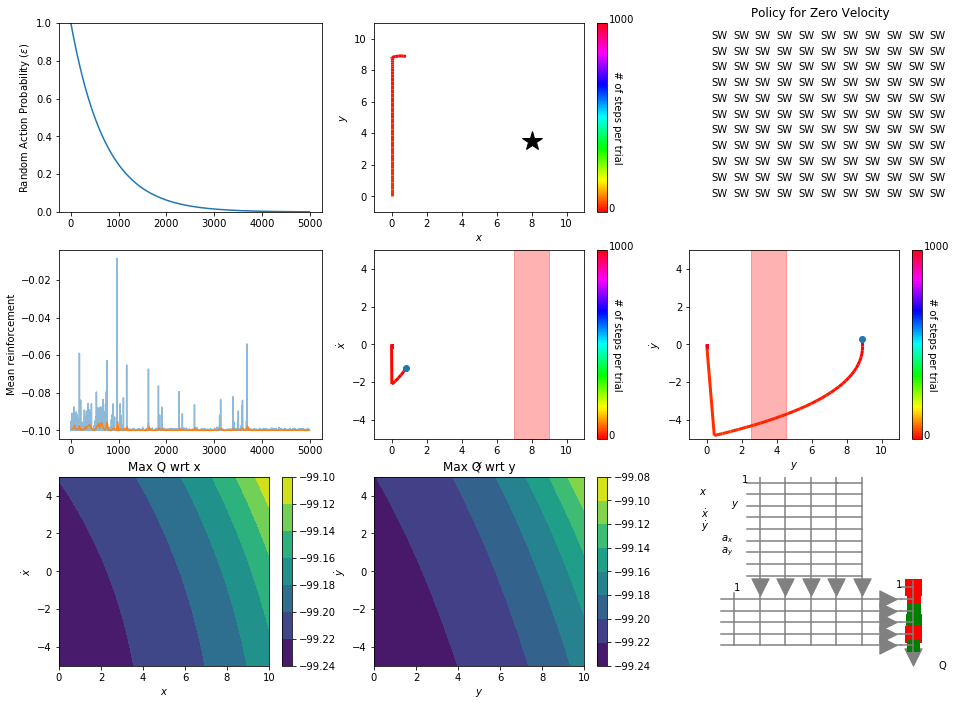

In [291]:
fig = plt.figure(figsize=(16,16))
plotStatus_2d(qnet_2d, X_2d, R_2d, trial_2d, epsilonTrace_2d, rtrace_2d)

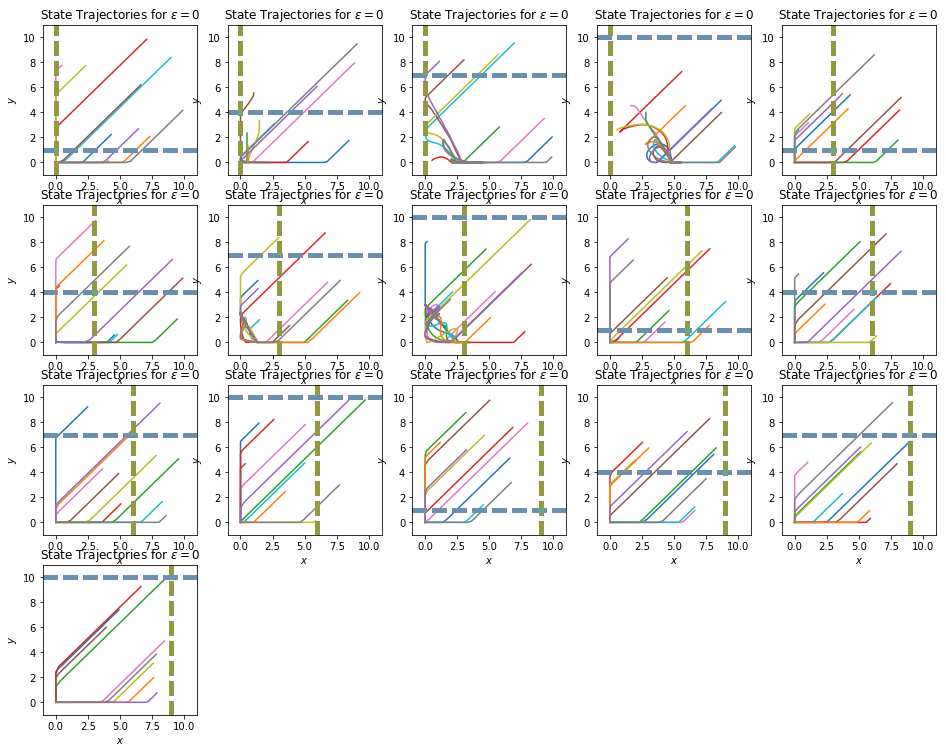

In [292]:
fig = plt.figure(figsize=(16,16))
for i,x in enumerate([0,3,6,9]):
    for j,y in enumerate([1,4,7,10]):
        plt.subplot(5,5,4*i+j+1)
        testIt_2d(qnet_2d, 10, 500, target = (x,y))

### Summary

Because the high dimensionality of data, including the random initial states and infinite moving directions, it is hard to train this model. 5000 iterations with 1000 step size and a final epsilon of 0.001 are still not enough to improve the mean reinforcement value. Interestingly in most test cases, the marbles are trying to move to the origin although some of them start to curve and try to find the correct target. Another thing is that a lot of the trajectories are diagonal, which could be due to that the two diagonal action terms [1,1] and [-1,-1] can most efficiently help a marble reach its goal.

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/41327).
